# Analyzing New York City (NYC) Taxi Trips
## Giza Systems
## By: Mostafa Khalil Karrar

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyspark
!pip install findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=1118fb7a0391454561713324fcc6c1b27406e187416b01e558a6072a06d19a83
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [3]:
!pyspark --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.5.0
      /_/
                        
Using Scala version 2.12.18, OpenJDK 64-Bit Server VM, 11.0.20.1
Branch HEAD
Compiled by user ubuntu on 2023-09-09T01:53:20Z
Revision ce5ddad990373636e94071e7cef2f31021add07b
Url https://github.com/apache/spark
Type --help for more information.


In [4]:
import findspark
findspark.init()

# Data Preparation

Import needed models and functions from pyspark library to initiate spark session and process the datasets

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, expr, unix_timestamp, to_timestamp, hour, dayofweek, date_format, isnull
from pyspark.sql.types import StructField, StructType, StringType, FloatType, IntegerType

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
spark = SparkSession.builder.appName("NY-Taxi").getOrCreate()
spark

In [8]:
!pwd

/content


In [9]:
data_file ="drive/MyDrive/SparkLabData/Assignment/NY-Taxi-Trips/sample.csv"
boroughs_file ="drive/MyDrive/SparkLabData/Assignment/NY-Taxi-Trips/nyc-boroughs.geojson"
image_file = "drive/MyDrive/SparkLabData/Assignment/NY-Taxi-Trips/nyc.PNG"

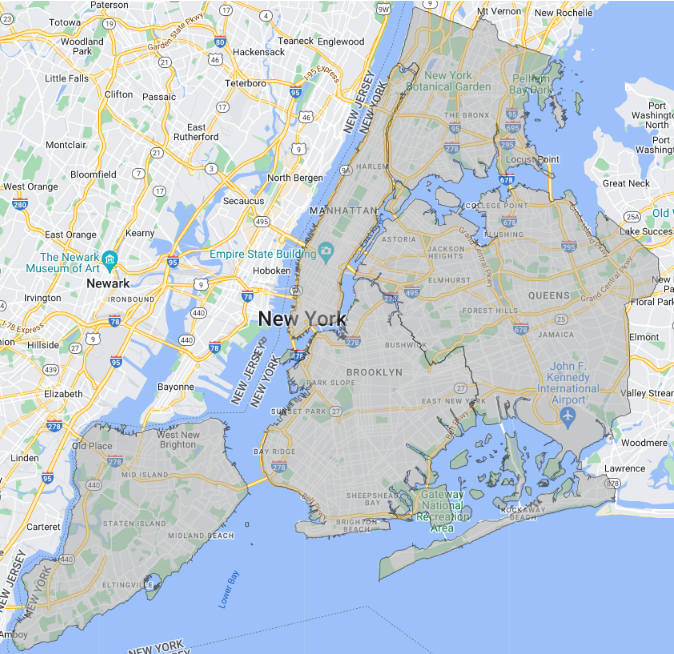

In [10]:
from IPython.display import Image
Image(filename=image_file)

Create Schema to read Trips data with the correct data type and attribute names

In [11]:
ManualSchema = StructType([
  StructField("medallion", StringType()),
  StructField("hack_license", StringType()),
  StructField("vendor_id", StringType()),
  StructField("rate_code", IntegerType()),
  StructField("store_and_fwd_flag", StringType()),
  StructField("pickup_datetime", StringType()),
  StructField("dropoff_datetime", StringType()),
  StructField("passenger_count", IntegerType()),
  StructField("trip_time_in_secs", IntegerType()),
  StructField("trip_distance", FloatType()),
  StructField("pickup_longitude", FloatType()),
  StructField("pickup_latitude", FloatType()),
  StructField("dropoff_longitude", FloatType()),
  StructField("dropoff_latitude", FloatType()),

])


Read Trips data into Spark DataFrame and display a sample of data and print the data schema

In [12]:
rawData = spark.read.format('csv')\
    .option('header', 'true')\
    .schema(ManualSchema)\
    .load(data_file)

df = rawData.toDF(
'medallion',
'hack_license',
'vendor_id',
'rate_code',
'store_and_fwd_flag',
'pickup_datetime',
'dropoff_datetime',
'passenger_count',
'trip_time_in_secs',
'trip_distance',
'pickup_longitude',
'pickup_latitude',
'dropoff_longitude',
'dropoff_latitude'
)


In [13]:
df.toPandas().head()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,1,N,2013-01-01 15:11:48,2013-01-01 15:18:10,4,382,1.0,-73.978165,40.757977,-73.989838,40.751171
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-06 00:18:35,2013-01-06 00:22:54,1,259,1.5,-74.006683,40.731781,-73.994499,40.750660
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-05 18:49:41,2013-01-05 18:54:23,1,282,1.1,-74.004707,40.737770,-74.009834,40.726002
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:54:15,2013-01-07 23:58:20,2,244,0.7,-73.974602,40.759945,-73.984734,40.759388
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:25:03,2013-01-07 23:34:24,1,560,2.1,-73.976250,40.748528,-74.002586,40.747868


In [14]:
print (df.schema)

StructType([StructField('medallion', StringType(), True), StructField('hack_license', StringType(), True), StructField('vendor_id', StringType(), True), StructField('rate_code', IntegerType(), True), StructField('store_and_fwd_flag', StringType(), True), StructField('pickup_datetime', StringType(), True), StructField('dropoff_datetime', StringType(), True), StructField('passenger_count', IntegerType(), True), StructField('trip_time_in_secs', IntegerType(), True), StructField('trip_distance', FloatType(), True), StructField('pickup_longitude', FloatType(), True), StructField('pickup_latitude', FloatType(), True), StructField('dropoff_longitude', FloatType(), True), StructField('dropoff_latitude', FloatType(), True)])


Remove unnecessary columns from the data and print the data schema after

In [15]:
columnsToDrop = ['medallion', 'vendor_id', 'rate_code', 'store_and_fwd_flag', 'passenger_count']
df = df.select([column for column in df.columns if column not in columnsToDrop])

In [16]:
print (df.schema)

StructType([StructField('hack_license', StringType(), True), StructField('pickup_datetime', StringType(), True), StructField('dropoff_datetime', StringType(), True), StructField('trip_time_in_secs', IntegerType(), True), StructField('trip_distance', FloatType(), True), StructField('pickup_longitude', FloatType(), True), StructField('pickup_latitude', FloatType(), True), StructField('dropoff_longitude', FloatType(), True), StructField('dropoff_latitude', FloatType(), True)])


## Data outlier filtration and transformation
adding some new attributes calculated from existing attributes and filter some trips have outlier values as described in details in project documentation

##### We need the following attributes to be added:
###### pickup_ut: pickup_datetime in unix timestamp format
###### dropoff_ut: dropoff_datetime in unix timestamp format
###### dropoff_hour: extract hour from dropoff_datetime
###### dropoff_weekday: extract weekday from dropoff_datetime
###### trip_duration: time in seconds from pickup to dropoff and dont depend on the column in the dataset

Hint: use **unix_timestamp** to convert datetime from string to unix timestamp which will be used to calculate trip duration and wiating time later, Also if you will do the task of ML you will need to **to_timestamp** convert string datetime from string to timestamp to extract hour and weekday using **date_format**

In [17]:
df = df.withColumn("pickup_ut", unix_timestamp(df["pickup_datetime"]))

In [18]:
df = df.withColumn("dropoff_ut", unix_timestamp(df["dropoff_datetime"]))

In [19]:
df = df.withColumn("dropoff_hour", hour(to_timestamp(df["dropoff_datetime"])))

In [20]:
df = df.withColumn("dropoff_weekday", dayofweek(to_timestamp(df["dropoff_datetime"])))

In [21]:
df = df.withColumn("trip_duration", df["dropoff_ut"] - df["pickup_ut"])

In [22]:
df.toPandas().head()

,hack_license,pickup_datetime,dropoff_datetime,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_ut,dropoff_ut,dropoff_hour,dropoff_weekday,trip_duration
0,BA96DE419E711691B9445D6A6307C170,2013-01-01 15:11:48,2013-01-01 15:18:10,382,1.0,-73.978165,40.757977,-73.989838,40.751171,1357053108,1357053490,15,3,382
1,9FD8F69F0804BDB5549F40E9DA1BE472,2013-01-06 00:18:35,2013-01-06 00:22:54,259,1.5,-74.006683,40.731781,-73.994499,40.750660,1357431515,1357431774,0,1,259
2,9FD8F69F0804BDB5549F40E9DA1BE472,2013-01-05 18:49:41,2013-01-05 18:54:23,282,1.1,-74.004707,40.737770,-74.009834,40.726002,1357411781,1357412063,18,7,282
3,51EE87E3205C985EF8431D850C786310,2013-01-07 23:54:15,2013-01-07 23:58:20,244,0.7,-73.974602,40.759945,-73.984734,40.759388,1357602855,1357603100,23,2,245
4,51EE87E3205C985EF8431D850C786310,2013-01-07 23:25:03,2013-01-07 23:34:24,560,2.1,-73.976250,40.748528,-74.002586,40.747868,1357601103,1357601664,23,2,561


In [23]:
df = df.filter(~(df["trip_duration"]<0) | (df["trip_duration"]>14400))

In [24]:
df.toPandas().head()

,hack_license,pickup_datetime,dropoff_datetime,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_ut,dropoff_ut,dropoff_hour,dropoff_weekday,trip_duration
0,BA96DE419E711691B9445D6A6307C170,2013-01-01 15:11:48,2013-01-01 15:18:10,382,1.0,-73.978165,40.757977,-73.989838,40.751171,1357053108,1357053490,15,3,382
1,9FD8F69F0804BDB5549F40E9DA1BE472,2013-01-06 00:18:35,2013-01-06 00:22:54,259,1.5,-74.006683,40.731781,-73.994499,40.750660,1357431515,1357431774,0,1,259
2,9FD8F69F0804BDB5549F40E9DA1BE472,2013-01-05 18:49:41,2013-01-05 18:54:23,282,1.1,-74.004707,40.737770,-74.009834,40.726002,1357411781,1357412063,18,7,282
3,51EE87E3205C985EF8431D850C786310,2013-01-07 23:54:15,2013-01-07 23:58:20,244,0.7,-73.974602,40.759945,-73.984734,40.759388,1357602855,1357603100,23,2,245
4,51EE87E3205C985EF8431D850C786310,2013-01-07 23:25:03,2013-01-07 23:34:24,560,2.1,-73.976250,40.748528,-74.002586,40.747868,1357601103,1357601664,23,2,561


Remove unnecessary columns from the data after filteration and print the data schema and sample of data

In [25]:
columnsToDrop = ['pickup_datetime', 'dropoff_datetime', 'trip_time_in_secs']
df = df.select([column for column in df.columns if column not in columnsToDrop])

In [26]:
df.toPandas().head()

,hack_license,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_ut,dropoff_ut,dropoff_hour,dropoff_weekday,trip_duration
0,BA96DE419E711691B9445D6A6307C170,1.0,-73.978165,40.757977,-73.989838,40.751171,1357053108,1357053490,15,3,382
1,9FD8F69F0804BDB5549F40E9DA1BE472,1.5,-74.006683,40.731781,-73.994499,40.750660,1357431515,1357431774,0,1,259
2,9FD8F69F0804BDB5549F40E9DA1BE472,1.1,-74.004707,40.737770,-74.009834,40.726002,1357411781,1357412063,18,7,282
3,51EE87E3205C985EF8431D850C786310,0.7,-73.974602,40.759945,-73.984734,40.759388,1357602855,1357603100,23,2,245
4,51EE87E3205C985EF8431D850C786310,2.1,-73.976250,40.748528,-74.002586,40.747868,1357601103,1357601664,23,2,561


In [27]:
print(df.schema)

StructType([StructField('hack_license', StringType(), True), StructField('trip_distance', FloatType(), True), StructField('pickup_longitude', FloatType(), True), StructField('pickup_latitude', FloatType(), True), StructField('dropoff_longitude', FloatType(), True), StructField('dropoff_latitude', FloatType(), True), StructField('pickup_ut', LongType(), True), StructField('dropoff_ut', LongType(), True), StructField('dropoff_hour', IntegerType(), True), StructField('dropoff_weekday', IntegerType(), True), StructField('trip_duration', LongType(), True)])


## Boroughs Dataset Reading

##### Source webpage: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
##### Source file: https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=GeoJSON

In [28]:
!pip install geojson

In [29]:
import geojson
from shapely.geometry import Point, Polygon

Read the dataset from the geojson file into geojson object

In [30]:
with open(boroughs_file, 'r') as file:
    geojson_object = geojson.load(file)

Loop over the geojson object to extract all Polygons objects and append it to a list with the corresponding Borough ID and name and the calculated Polygon area

In [31]:
boroughs_list=[]

for feature in geojson_object['features']:
      borough_id = feature['properties']['boro_code']
      borough_name = feature['properties']['boro_name']

      coordinates = feature['geometry']['coordinates']
      polygons = [Polygon(coords[0]) for coords in coordinates]
      polygon_area = feature['properties']['shape_area']
      boroughs_list.append({
          'BoroughID': borough_id,
          'BoroughName': borough_name,
          'PolygonArea': polygon_area,
          'Polygons': polygons
        })

In [32]:
print(boroughs_list)

[{'BoroughID': '4', 'BoroughName': 'Queens', 'PolygonArea': '3040205594.95', 'Polygons': [<POLYGON ((-73.826 40.591, -73.826 40.59, -73.826 40.59, -73.826 40.59, -73....>, <POLYGON ((-73.832 40.593, -73.831 40.591, -73.834 40.589, -73.834 40.589, -...>, <POLYGON ((-73.81 40.6, -73.81 40.6, -73.81 40.6, -73.81 40.6, -73.81 40.6, ...>, <POLYGON ((-73.8 40.607, -73.8 40.607, -73.8 40.607, -73.8 40.607, -73.8 40....>, <POLYGON ((-73.83 40.607, -73.83 40.607, -73.83 40.607, -73.83 40.607, -73.8...>, <POLYGON ((-73.797 40.609, -73.796 40.609, -73.796 40.609, -73.796 40.609, -...>, <POLYGON ((-73.827 40.609, -73.827 40.609, -73.827 40.609, -73.827 40.609, -...>, <POLYGON ((-73.832 40.61, -73.832 40.61, -73.832 40.61, -73.832 40.61, -73.8...>, <POLYGON ((-73.767 40.614, -73.767 40.614, -73.767 40.614, -73.767 40.614, -...>, <POLYGON ((-73.785 40.618, -73.785 40.618, -73.785 40.618, -73.785 40.618, -...>, <POLYGON ((-73.767 40.615, -73.767 40.615, -73.768 40.615, -73.771 40.616, -...>, <POLYGON

As per previous output each borough consist of more than one Polygon, so we will sort the list by Borough ID then by Polygon areas to accelerate search and print the list

In [33]:
boroughs_list = sorted(boroughs_list, key=lambda x: (x['BoroughID'],x['PolygonArea']))

In [34]:
print(boroughs_list)

[{'BoroughID': '1', 'BoroughName': 'Manhattan', 'PolygonArea': '636620785.519', 'Polygons': [<POLYGON ((-74.011 40.684, -74.012 40.684, -74.012 40.684, -74.01 40.685, -7...>, <POLYGON ((-74.005 40.688, -74.006 40.687, -74.008 40.687, -74.007 40.688, -...>, <POLYGON ((-74.004 40.689, -74.005 40.688, -74.007 40.689, -74.006 40.69, -7...>, <POLYGON ((-74.003 40.69, -74.003 40.69, -74.006 40.69, -74.005 40.691, -74....>, <POLYGON ((-74.044 40.69, -74.044 40.69, -74.043 40.69, -74.043 40.69, -74.0...>, <POLYGON ((-74.001 40.691, -74.001 40.691, -74.005 40.692, -74.004 40.693, -...>, <POLYGON ((-74.017 40.693, -74.015 40.693, -74.015 40.693, -74.015 40.693, -...>, <POLYGON ((-74.002 40.693, -74.002 40.692, -74.004 40.693, -74.004 40.694, -...>, <POLYGON ((-74.001 40.694, -74.001 40.694, -74.003 40.695, -74.003 40.695, -...>, <POLYGON ((-74 40.697, -74 40.697, -74 40.697, -74 40.697, -74 40.697, -73.9...>, <POLYGON ((-73.998 40.698, -73.999 40.697, -74.001 40.698, -74 40.699, -73.9...>, <POLY

As boroughs list have limited number of items we can broadcast it into memory in each Spark session worker for fast accessing

In [35]:
spark.sparkContext.broadcast(boroughs_list)

Create a function which take longitude and latitude values of any pickup or drop-off points and check the existence of this point into one of the Polygon objects in the boroughs list then return the borough name

In [36]:
def locate(longitude, latitiude):
  point = Point(longitude,latitiude)

  for borough in boroughs_list:
    for polygon in borough['Polygons']:
      if polygon.contains(point):
        return (borough['BoroughName'])

From previous function we have to create a spark user defined function to be able to use it with the spark dataframe transformation

In [37]:
locate_udf = udf(locate, StringType())

Add two new columns to the dataframe include the borough name of pickup and drop-off calculated based on corresponding longitude and latitude values using the previous created function

In [38]:
df = df.withColumn('pickup_borough', locate_udf(df['pickup_longitude'], df['pickup_latitude']))

In [39]:
df = df.withColumn('dropoff_borough', locate_udf(df['dropoff_longitude'], df['dropoff_latitude']))

Remove unnecessary columns of longitude and latitude values after transform it to borough name and print sample of data schema after

In [40]:
columnsToDrop = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
df = df.select([column for column in df.columns if column not in columnsToDrop])

In [41]:
df.toPandas().head()

,hack_license,trip_distance,pickup_ut,dropoff_ut,dropoff_hour,dropoff_weekday,trip_duration,pickup_borough,dropoff_borough
0,BA96DE419E711691B9445D6A6307C170,1.0,1357053108,1357053490,15,3,382,Manhattan,Manhattan
1,9FD8F69F0804BDB5549F40E9DA1BE472,1.5,1357431515,1357431774,0,1,259,Manhattan,Manhattan
2,9FD8F69F0804BDB5549F40E9DA1BE472,1.1,1357411781,1357412063,18,7,282,Manhattan,Manhattan
3,51EE87E3205C985EF8431D850C786310,0.7,1357602855,1357603100,23,2,245,Manhattan,Manhattan
4,51EE87E3205C985EF8431D850C786310,2.1,1357601103,1357601664,23,2,561,Manhattan,Manhattan


In [42]:
df.printSchema()

root
 |-- hack_license: string (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- pickup_ut: long (nullable = true)
 |-- dropoff_ut: long (nullable = true)
 |-- dropoff_hour: integer (nullable = true)
 |-- dropoff_weekday: integer (nullable = true)
 |-- trip_duration: long (nullable = true)
 |-- pickup_borough: string (nullable = true)
 |-- dropoff_borough: string (nullable = true)



Filter trips have null value for pickup or drrop-off borough which mean its outside the range of NYC (Hist: use **isnull** spark function)

In [43]:
df = df.filter(~(isnull("pickup_borough") | isnull("dropoff_borough")))

In [44]:
df.toPandas().head()

,hack_license,trip_distance,pickup_ut,dropoff_ut,dropoff_hour,dropoff_weekday,trip_duration,pickup_borough,dropoff_borough
0,BA96DE419E711691B9445D6A6307C170,1.0,1357053108,1357053490,15,3,382,Manhattan,Manhattan
1,9FD8F69F0804BDB5549F40E9DA1BE472,1.5,1357431515,1357431774,0,1,259,Manhattan,Manhattan
2,9FD8F69F0804BDB5549F40E9DA1BE472,1.1,1357411781,1357412063,18,7,282,Manhattan,Manhattan
3,51EE87E3205C985EF8431D850C786310,0.7,1357602855,1357603100,23,2,245,Manhattan,Manhattan
4,51EE87E3205C985EF8431D850C786310,2.1,1357601103,1357601664,23,2,561,Manhattan,Manhattan


Get the total number of trips in the dataframe after all above transformations

In [45]:
count = df.count()
print(count)

97507


Save the Dataframe in parquet format into spark cluster to be easy to load in it in matter time without redoing the previous transformations before start the modeling phase,
So I will run it once and no need to run it again

In [46]:
output_path = "drive/MyDrive/SparkLabData/Assignment/NY-Taxi-Trips/parquet_data"
df.write.mode("overwrite").parquet(output_path)

Read the preprocessed data into a Dataframe in just a few seconds and print sample of data and schema

In [47]:
preprocessed_df = spark.read.parquet(output_path)

In [48]:
preprocessed_df.toPandas().head()

,hack_license,trip_distance,pickup_ut,dropoff_ut,dropoff_hour,dropoff_weekday,trip_duration,pickup_borough,dropoff_borough
0,BA96DE419E711691B9445D6A6307C170,1.0,1357053108,1357053490,15,3,382,Manhattan,Manhattan
1,9FD8F69F0804BDB5549F40E9DA1BE472,1.5,1357431515,1357431774,0,1,259,Manhattan,Manhattan
2,9FD8F69F0804BDB5549F40E9DA1BE472,1.1,1357411781,1357412063,18,7,282,Manhattan,Manhattan
3,51EE87E3205C985EF8431D850C786310,0.7,1357602855,1357603100,23,2,245,Manhattan,Manhattan
4,51EE87E3205C985EF8431D850C786310,2.1,1357601103,1357601664,23,2,561,Manhattan,Manhattan


In [49]:
preprocessed_df.printSchema()

root
 |-- hack_license: string (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- pickup_ut: long (nullable = true)
 |-- dropoff_ut: long (nullable = true)
 |-- dropoff_hour: integer (nullable = true)
 |-- dropoff_weekday: integer (nullable = true)
 |-- trip_duration: long (nullable = true)
 |-- pickup_borough: string (nullable = true)
 |-- dropoff_borough: string (nullable = true)



Validate the count of trips after reading from the parquet file

In [50]:
count = preprocessed_df.count()
print(count)

97507


## Task-1: Calculating Average Waiting Time

Using pyspark window function and partition data with driver hack license and order data by pickup time to get the next trip of the current trip in a new column "next_trip_pickup_ut" and print sample of new Dataframe trips_waiting_time

In [51]:
from pyspark.sql.window import Window
from pyspark.sql.functions import max,min,avg,sum,asc,desc,lead

In [52]:
window_fun = Window.partitionBy(preprocessed_df['hack_license']).orderBy(preprocessed_df['pickup_ut'])

In [53]:
df_average = preprocessed_df.withColumn("next_trip_pickup_ut", lead("pickup_ut").over(window_fun))

In [54]:
df_average.toPandas().head(20)

,hack_license,trip_distance,pickup_ut,dropoff_ut,dropoff_hour,dropoff_weekday,trip_duration,pickup_borough,dropoff_borough,next_trip_pickup_ut
0,001C8AAB90AEE49F36FCAA7B4136C81A,2.89,1358043720,1358044320,2,1,600,Manhattan,Manhattan,1.358051e+09
1,001C8AAB90AEE49F36FCAA7B4136C81A,11.39,1358050740,1358052060,4,1,1320,Manhattan,Brooklyn,1.358058e+09
2,001C8AAB90AEE49F36FCAA7B4136C81A,3.64,1358058000,1358058600,6,1,600,Manhattan,Manhattan,1.358059e+09
3,001C8AAB90AEE49F36FCAA7B4136C81A,0.81,1358059200,1358059440,6,1,240,Manhattan,Manhattan,NaN
4,0025133AD810DBE80D35FCA8BF0BCA1F,2.74,1358044620,1358045160,2,1,540,Manhattan,Manhattan,1.358048e+09
5,0025133AD810DBE80D35FCA8BF0BCA1F,3.07,1358047560,1358048460,3,1,900,Manhattan,Manhattan,NaN
6,00447A6197DBB329FBF764139ACA6EC4,8.83,1358081040,1358081940,12,1,900,Queens,Brooklyn,1.358085e+09
7,00447A6197DBB329FBF764139ACA6EC4,17.84,1358084880,1358087040,14,1,2160,Queens,Manhattan,1.358092e+09
8,00447A6197DBB329FBF764139ACA6EC4,12.49,1358092500,1358094000,16,1,1500,Queens,Queens,1.358099e+09
9,00447A6197DBB329FBF764139ACA6EC4,2.95,1358098800,1358099700,17,1,900,Manhattan,Manhattan,1.358100e+09


Calculate the waiting time by calculate the differncae between the drop-off time and calculated next trip pickup time to be the lable of the model and print a sample of data and schema

In [55]:
df_average = df_average.withColumn("waiting_time", df_average['next_trip_pickup_ut']-df_average['dropoff_ut'])

In [56]:
df_average.toPandas().head()

,hack_license,trip_distance,pickup_ut,dropoff_ut,dropoff_hour,dropoff_weekday,trip_duration,pickup_borough,dropoff_borough,next_trip_pickup_ut,waiting_time
0,001C8AAB90AEE49F36FCAA7B4136C81A,2.89,1358043720,1358044320,2,1,600,Manhattan,Manhattan,1.358051e+09,6420.0
1,001C8AAB90AEE49F36FCAA7B4136C81A,11.39,1358050740,1358052060,4,1,1320,Manhattan,Brooklyn,1.358058e+09,5940.0
2,001C8AAB90AEE49F36FCAA7B4136C81A,3.64,1358058000,1358058600,6,1,600,Manhattan,Manhattan,1.358059e+09,600.0
3,001C8AAB90AEE49F36FCAA7B4136C81A,0.81,1358059200,1358059440,6,1,240,Manhattan,Manhattan,NaN,NaN
4,0025133AD810DBE80D35FCA8BF0BCA1F,2.74,1358044620,1358045160,2,1,540,Manhattan,Manhattan,1.358048e+09,2400.0


In [57]:
df_average.printSchema()

root
 |-- hack_license: string (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- pickup_ut: long (nullable = true)
 |-- dropoff_ut: long (nullable = true)
 |-- dropoff_hour: integer (nullable = true)
 |-- dropoff_weekday: integer (nullable = true)
 |-- trip_duration: long (nullable = true)
 |-- pickup_borough: string (nullable = true)
 |-- dropoff_borough: string (nullable = true)
 |-- next_trip_pickup_ut: long (nullable = true)
 |-- waiting_time: long (nullable = true)



Filter outlier data which have negative waiting time or waiting time for more than 4 hours

In [58]:
df_average = df_average.filter(~(df_average["waiting_time"]<0) | (df_average["waiting_time"]>14400))

In [59]:
df_average.toPandas().head(20)

,hack_license,trip_distance,pickup_ut,dropoff_ut,dropoff_hour,dropoff_weekday,trip_duration,pickup_borough,dropoff_borough,next_trip_pickup_ut,waiting_time
0,001C8AAB90AEE49F36FCAA7B4136C81A,2.89,1358043720,1358044320,2,1,600,Manhattan,Manhattan,1358050740,6420
1,001C8AAB90AEE49F36FCAA7B4136C81A,11.39,1358050740,1358052060,4,1,1320,Manhattan,Brooklyn,1358058000,5940
2,001C8AAB90AEE49F36FCAA7B4136C81A,3.64,1358058000,1358058600,6,1,600,Manhattan,Manhattan,1358059200,600
3,0025133AD810DBE80D35FCA8BF0BCA1F,2.74,1358044620,1358045160,2,1,540,Manhattan,Manhattan,1358047560,2400
4,00447A6197DBB329FBF764139ACA6EC4,8.83,1358081040,1358081940,12,1,900,Queens,Brooklyn,1358084880,2940
5,00447A6197DBB329FBF764139ACA6EC4,17.84,1358084880,1358087040,14,1,2160,Queens,Manhattan,1358092500,5460
6,00447A6197DBB329FBF764139ACA6EC4,12.49,1358092500,1358094000,16,1,1500,Queens,Queens,1358098800,4800
7,00447A6197DBB329FBF764139ACA6EC4,2.95,1358098800,1358099700,17,1,900,Manhattan,Manhattan,1358099940,240
8,006313464EC98A24BB4EBC1E2419E439,3.41,1358062560,1358063280,7,1,720,Manhattan,Manhattan,1358064960,1680
9,006313464EC98A24BB4EBC1E2419E439,0.74,1358064960,1358065200,8,1,240,Manhattan,Manhattan,1358067060,1860


Now we are ready to calulcate the average waiting time, this will calulate it in minutes, as the requested waiting time is required per destination borough so we'll group by dropoff_borough as the waiting time is calculated after the trip finished so it represents the waiting time in the drop-off location (destination) as requested.

In [60]:
avg_waiting_time = df_average.groupBy("dropoff_borough").agg({"waiting_time": "avg"}).withColumnRenamed("avg(waiting_time)", "average_waiting_time")
avg_waiting_time = avg_waiting_time.withColumn("average_waiting_time_minutes", avg_waiting_time["average_waiting_time"] / 60)

In [95]:
avg_waiting_time.toPandas().head()

,dropoff_borough,average_waiting_time,average_waiting_time_minutes
0,Queens,6003.290196,100.054837
1,Brooklyn,6759.483310,112.658055
2,Staten Island,11250.000000,187.500000
3,Manhattan,1855.749972,30.929166
4,Bronx,4799.628483,79.993808


Ploting the Output

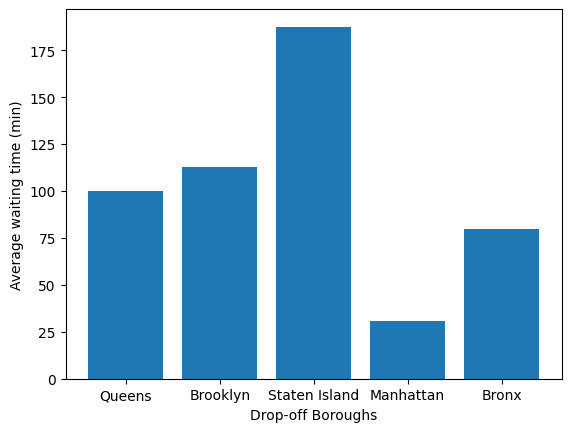

In [62]:
import matplotlib.pyplot as plt
plt.bar(avg_waiting_time.toPandas()["dropoff_borough"], avg_waiting_time.toPandas()["average_waiting_time_minutes"])
plt.xlabel('Drop-off Boroughs')
plt.ylabel('Average waiting time (min)')
plt.show()

## Task-2: The number of trips that started and ended within the same borough

In [63]:
same_borough_trips_df = preprocessed_df.filter(preprocessed_df["pickup_borough"] == preprocessed_df["dropoff_borough"])
same_borough_trips_df.count()

86074

## Task-3: The number of trips that started in one borough and ended in another one

In [64]:
different_borough_trips_df = preprocessed_df.filter(preprocessed_df["pickup_borough"] != preprocessed_df["dropoff_borough"])
different_borough_trips_df.count()

11433

## Task-4 (Bouns): Build ML model to predict trip duration time in minutes based using pyspark.ml

### Modeling and Evaluation
Import needed models from pyspark.ml library

In [65]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

Import needed models from datetime library to calculate training and testing time for each model

In [66]:
from datetime import datetime, timedelta

### Trip Duration Model
randomly split data into training and testing to be used in all trip duration models

In [69]:
(trainingData, testData) = preprocessed_df.randomSplit([0.8,0.2])

list categorical columns

In [73]:
cat_cols = [item[0] for item in preprocessed_df.dtypes if item[1].startswith('string')]
cat_cols

['hack_license', 'pickup_borough', 'dropoff_borough']

In [74]:
cat_cols.append('dropoff_weekday')
print(cat_cols)

['hack_license', 'pickup_borough', 'dropoff_borough', 'dropoff_weekday']


Make String Indexer for categorical columns

In [75]:
indexers = [StringIndexer(
    inputCol=column,
    outputCol=column + '_index',
    handleInvalid='keep') for column in cat_cols]

Make One Hot Encoder for indexed columns

In [76]:
encoders = [OneHotEncoder(
    inputCol=column + '_index',
    outputCol= column + '_encoded') for column in cat_cols]

Get Required Features for the models

In [96]:
requiredFeatures = [
    'dropoff_hour',
    'dropoff_weekday_encoded',
    'pickup_borough_encoded',
    'trip_distance',
    'dropoff_borough_encoded',
]

Vector Assembler for Required Features

In [97]:
assembler = VectorAssembler(inputCols=requiredFeatures, outputCol='features')

#### Random Forest Model to predict Trip Duration

Initiate the model

In [98]:
rf = RandomForestRegressor(labelCol='trip_duration',
                            featuresCol='features',
                            maxDepth=5, numTrees=10)

print model default parameters

In [99]:
print(rf.explainParams())

bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the featur

create model pipeline

In [100]:
pipeline = Pipeline(stages=indexers + encoders + [assembler, rf])

#### Training

In [101]:
model = pipeline.fit(trainingData)

####  Prediction

In [102]:
rf_trip_duration_predictions = model.transform(testData)

In [103]:
rf_trip_duration_predictions.toPandas().tail(20)

,hack_license,trip_distance,pickup_ut,dropoff_ut,dropoff_hour,dropoff_weekday,trip_duration,pickup_borough,dropoff_borough,hack_license_index,pickup_borough_index,dropoff_borough_index,dropoff_weekday_index,hack_license_encoded,pickup_borough_encoded,dropoff_borough_encoded,dropoff_weekday_encoded,features,prediction
19367,FF4CCCFF03CDB40E5E1DB7685734AD4F,12.00,1358099580,1358101140,18,1,1560,Queens,Queens,7896.0,1.0,1.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(18.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1267.988214
19368,FF517EFF90A939E0309769931E9C2414,0.94,1358088660,1358089080,14,1,420,Manhattan,Manhattan,2007.0,0.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(14.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",384.700754
19369,FF517EFF90A939E0309769931E9C2414,1.35,1358091060,1358091360,15,1,300,Manhattan,Manhattan,2007.0,0.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(15.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",433.323756
19370,FF517EFF90A939E0309769931E9C2414,10.30,1358092740,1358094240,16,1,1500,Manhattan,Queens,2007.0,0.0,1.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(16.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",1440.535603
19371,FF571D0F99720CD16B15E90D644F1415,15.95,1358076720,1358077920,11,1,1200,Manhattan,Queens,7897.0,0.0,1.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(11.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",1688.025791
19372,FF5ACF4EABD331287DA9C9251F8DE92E,0.98,1358085240,1358085840,14,1,600,Manhattan,Manhattan,4377.0,0.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(14.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",384.700754
19373,FF60BDF7704EFEF47C77BB80973FADC9,0.96,1358087940,1358088120,14,1,180,Manhattan,Manhattan,2008.0,0.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(14.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",384.700754
19374,FF60BDF7704EFEF47C77BB80973FADC9,2.60,1358088900,1358089800,15,1,900,Manhattan,Manhattan,2008.0,0.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(15.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",628.230803
19375,FF60BDF7704EFEF47C77BB80973FADC9,4.35,1358084940,1358085660,14,1,720,Manhattan,Manhattan,2008.0,0.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(14.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",956.538697
19376,FF6268D2823F3EA63CEA4006D4ED5EFD,11.74,1358093460,1358097480,17,1,4020,Queens,Manhattan,7898.0,1.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(17.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1509.025123


#### Evaluation
use Root Mean Squared Error (RMSE) evaluator as below


In [104]:
evaluator = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(rf_trip_duration_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 230.476


#### Save the Model
save the model for later load and use without need to re-train it again

In [105]:
model_path = "drive/MyDrive/SparkLabData/Assignment/NY-Taxi-Trips/my_model"
rf.write().overwrite().save(model_path)